# EEG Problem Set: Preprocessing
## Part 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from mne import set_log_level
set_log_level(verbose=False)
%matplotlib inline

## Instructions

We will be analyzing EEG data from one participant who completed an [oddball paradigm](https://en.wikipedia.org/wiki/Oddball_paradigm). 

In this first notebook, you will preprocess the raw data. Specifically, you will (1) load and inspect the raw data, (2) mark bad channels, (3) filter the data, and (4) remove eyeblinks with independent components analysis. Question prompts are included throughout the notebook to guide you in analysis. Note that these require answers to earn full points.

## Step 1: Load and inspect raw data

In [2]:
from mne.io import read_raw_fif

## Load data.
raw = read_raw_fif('sub-01_task-digitsymbol_raw.fif', preload=True, verbose=False)
print(raw)

<Raw | sub-01_task-digitsymbol_raw.fif, 66 x 238800 (1990.0 s), ~120.3 MB, data loaded>


### Inspecting metadata
Inspect the recording metadata with `raw.info` and answer the following questions:

**Q**: How many EEG channels does this dataset have? How many peripheral channels?

> 64 EEG channels, 1 EOG channel

**Q**: What is the sampling frequency of the data?

> 120 Hz

**Q**: Has the data already been filtered?

> Yes, the data have been lowpassed filtered (60 Hz).

In [3]:
raw.info

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 1 EOG, 1 STIM
 custom_ref_applied: False
 dig: 64 items (64 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 60.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 66
 projs: []
 sfreq: 120.0 Hz
>

### Channel layout
Plot the channel layout below.

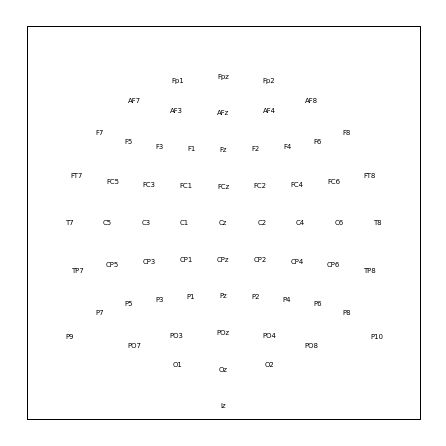

In [4]:
from mne.channels import find_layout
from mne.viz import plot_layout

## Locate senor layout.
layout = find_layout(raw.info)

## Plot.
plot_layout(layout);

**Q**: Are the channels organized according to the [10-20 international electrode placement system](https://en.wikipedia.org/wiki/10%E2%80%9320_system_(EEG))?

> Yes.


## Step 2: Marking Bad Channels

Take a moment to browse the raw data.

---

**Note:** The raw data visualizor requires the *matplotlib osx* or *qt5* backend. This cannot be called in the same notebook as the *matplotlib inline* backend. For your convenience, code for inspecting raw data has been stored in **eeg-ps-inspector.ipynb**. 

---

**Q**: Do any of the channels look bad? 

> TP7

Mark the bad channel (if any) below.

In [5]:
## Designate bad channels.
raw.info['bads'] = ['TP7']

## Step 3: Filtering

Apply a bandpass filter of [0.5, 30 Hz] to the data.

**Note**: Use `mne.pick_types` to apply the filter only to the EEG channels.

In [5]:
from mne import pick_types

## Define EEG channels.
picks = pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False)

## Apply bandpass filter.
raw = raw.filter(0.5, 30, picks=picks, method='fir', phase='zero')

## Step 4: Independent Components Analysis (ICA)

In this final step, we will perform ICA to remove eyeblinks from the data. Use the code from class to fit an ICA model with 25 components to the data. 

**Note:** The eyeblink artifact is exceedingly large in magnitude in the frontal channels (e.g. FPz, FP1, FP2). You will need to use a large amplitude rejection threshold in order to avoid rejecting many epochs from the ICA model.

In [6]:
from mne.preprocessing import ICA

## Define parameters.
n_components = 25           
reject = dict(eeg=500e-6)
method = 'fastica'
decim = 3 

## Initialize ICA object.
ica = ICA(n_components=n_components, method=method, random_state=47404)

## Fit ICA to data.
picks = pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False)
ica.fit(raw, picks=picks, decim=decim, reject=reject)
print(ica)

<ICA | raw data decomposition, fit (fastica): 79440 samples, 25 components, channels used: "eeg">


Next, plot the scalp topography of each component to identify artifactual-looking components.

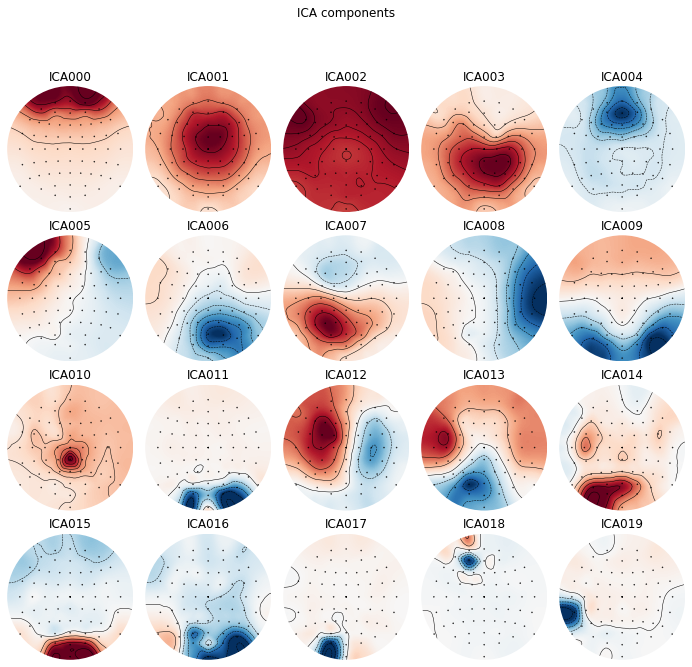

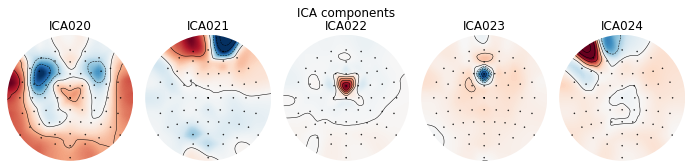

In [7]:
ica.plot_components();

**Q**: Based on first impressions, which components look like ocular artifact?

> ICA000, ICA004

To more objectively identify artifactual components, you will construct eyeblink epochs to correlate with each component. Use the `create_eog_epochs` code we covered in class. Plot the resulting eyeblinks. 

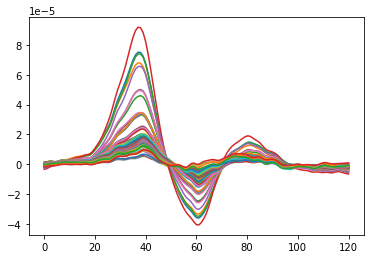

In [9]:
from mne.preprocessing import create_eog_epochs

## Identify eyeblink events.
reject = dict(eeg=500e-6)
picks = pick_types(raw.info, meg=False, eeg=True, eog=True, stim=False)
eog_epochs = create_eog_epochs(raw, ch_name='EOG', picks=picks, reject=reject)

## Compute average eyeblink and plot.
eog_average = eog_epochs.average()
plt.plot(eog_average.data.T);

Next we detect EOG related components using correlation. Detection is based on Pearson correlation between the filtered data and the filtered EOG channel. 

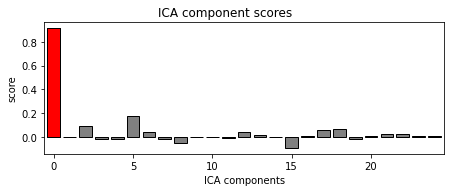

In [10]:
## Detect EOG components using correlation.
eog_inds, scores = ica.find_bads_eog(eog_epochs)

## Plot scores.
ica.plot_scores(scores, exclude=eog_inds);

**Q**: Which components most strongly correlate with the eyeblinks?

> ICA000, ICA004

Inspect the source timecourse within the time window of our EOG average.

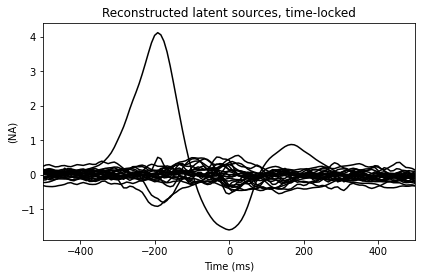

In [12]:
## Plot source reconstruction.
ica.plot_sources(eog_average);

Now visualize how we would modify our signals if we removed this component from the data.

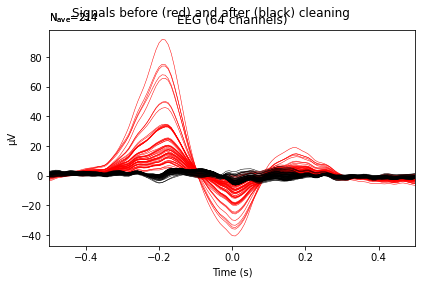

In [13]:
ica.plot_overlay(eog_average, exclude=eog_inds, show=False);

Register any bad components using the `ica.exclude` attribute.

In [14]:
ica.exclude.extend(eog_inds)

Now remove the effects of the rejected components using the `apply` method. Apply the ICA transformation to a copy of the original raw data.

In [15]:
## Copy raw data.
raw_ica = raw.copy()

## Apply ICA decomposition and transformation.
ica.apply(raw_ica)

<Raw | sub-01_task-digitsymbol_raw.fif, 66 x 238800 (1990.0 s), ~120.3 MB, data loaded>

## Step 5: Save the Preprocessed Data

Finally, save the new preprocessed raw data for use in the next notebook. Save it as *sub-01_task-digitsymbol_preproc_raw.fif*.

In [16]:
## Save preprocessed data.
raw_ica.save('sub-01_task-digitsymbol_preproc_raw.fif', overwrite=True)

# Part 2
## Instructions

In the second part of this problem set, you will be performing an ERP analysis on the preprocessed data. First let's describe the task in greater detail. 

This experiment is based on the oddball paradigm used in [Luck et al., (2009)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1469-8986.2009.00817.x). In the oddball paradigm, a letter or digit was presented every 1100-1500 ms. Subjects were instructed to press a button with one hand for digits and with the other hand for letters. For a given trial block, either the letters or the digits were rare (20%) and the other category was frequent (80%). Thus, the stimulus category and the probability were counterbalanced. The probability manipulation was designed to isolate the probability-sensitive P300 component. Different event codes were used for the digits when they were rare, the digits when they were frequent, the letters when they were rare, and the letters when they were frequent. 

The P300 is a neural marker of surprise. As such, we expect a larger P300 during the rare trials than for the frequent trials. In this second notebook, you will analyze the difference (if any) in P300s between conditions. Specifically, you will (1) epoch the raw data, (2) organize the data by condition, (3) perform permutation testing, and (4) visualize the evoked potentials.

We begin by loading in the preprocessed data.

In [16]:
from mne.io import read_raw_fif

## Load data.
raw = read_raw_fif('sub-01_task-digitsymbol_preproc_raw.fif', preload=True, verbose=False)
print(raw)

<Raw  |  sub-01_task-digitsymbol_preproc_raw.fif, n_channels x n_times : 66 x 238800 (1990.0 sec), ~120.4 MB, data loaded>


## Step 1: Gather Events

In this first step, we will read in all of the trial events from the raw data. To do this, use `mne.events_from_annotations`. Import the function and apply it to the raw data.

In [17]:
from mne import events_from_annotations

## Gather events.
events, event_id = events_from_annotations(raw)

Next, use `plot_events` from `mne.viz` to visualize out the events. 

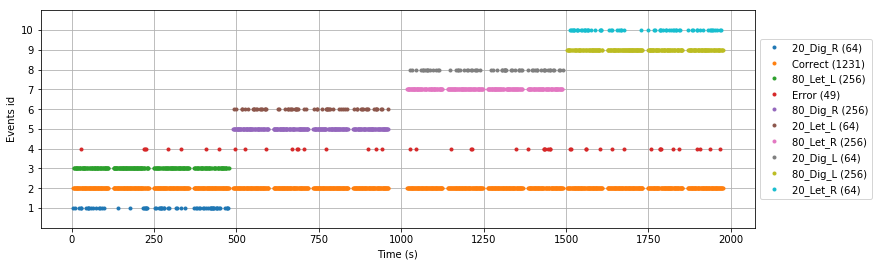

In [18]:
from mne.viz import plot_events

## Plot the events.
fig, ax = plt.subplots(1,1,figsize=(16,4))
fig = plot_events(events, raw.info['sfreq'], raw.first_samp, event_id=event_id, axes=ax);

**Q**: How many trial types are there? How are they organized?

> 8 trial types, organized by frequency (80, 20), symbol (digit, letter), and response (left, right).

**Q**: How many response types are there? What are they?

> Two: correct and error.

## Step 2: Epoching

Now we will perform epoching. First we must define the **event_id**. Remember that event IDs are Python dictionaries, where the keys are the event labels (e.g. 20_Dig_R, 80_Dig_R) and the values are the event integers (see y-axis of plot above).

In the following, include only the events correspdonding to the onset of the stimuli (i.e. do not include the response events). 

In [19]:
## Define event id.
event_id = {'20_Dig_R': 1, '80_Let_L': 3, '80_Dig_R': 5, '20_Let_L': 6,
            '80_Let_R': 7, '20_Dig_L': 8, '80_Dig_L': 9, '20_Let_R': 10}

Now we must define the time window for our epochs. We will use:
- tmin: 200ms
- tmax: 1000ms
- baseline: = (None, 0)

In [20]:
## Define epoch lengths.
tmin = -0.2
tmax = 1.0
baseline = (None, 0)

Now we must define our rejection criterion. Define a reasonable threshold.

In [21]:
## Define channels + rejection.
reject = dict(eeg = 100e-6)

Now perform epoching using `mne.Epochs`. 

**Note:** Use `pick_types` to include only the EEG channels (i.e. we no longer need the EOG or trigger channels).

In [22]:
from mne import Epochs, pick_types

## Perform epoching.
picks = pick_types(raw.info, meg=False, eeg=True)
epochs = Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=baseline,
                picks=picks, reject=reject, preload=True, verbose=False)
print(epochs)

<Epochs  |   1264 events (all good), -0.2 - 1 sec, baseline [None, 0], ~88.3 MB, data loaded,
 '20_Dig_L': 63
 '20_Dig_R': 61
 '20_Let_L': 64
 '20_Let_R': 64
 '80_Dig_L': 254
 '80_Dig_R': 254
 '80_Let_L': 253
 '80_Let_R': 251>


Now we drop bad epochs. 

In [23]:
## Drop bad epochs.
epochs.drop_bad()
print(epochs)

<Epochs  |   1264 events (all good), -0.2 - 1 sec, baseline [None, 0], ~88.3 MB, data loaded,
 '20_Dig_L': 63
 '20_Dig_R': 61
 '20_Let_L': 64
 '20_Let_R': 64
 '80_Dig_L': 254
 '80_Dig_R': 254
 '80_Let_L': 253
 '80_Let_R': 251>


**Q**: How many trials are left per condition after dropping bad epochs? 
> See above.

Finally, let's save our epochs. Save the data as *sub-01_task-digitsymbol-epo.fif*.

In [24]:
## Drop bad epochs.
epochs.save('sub-01_task-digitsymbol-epo.fif')